In [ ]:
#conda activate epymorph_graphviz

In [ ]:
import os

# Prepend TeX Live 2025 bin directory to PATH
os.environ['PATH'] = '/scratch/ope4/texlive/2025/bin/x86_64-linux:' + os.environ['PATH']

# Optional: check that the correct latex is found
!which latex
!latex --version


In [ ]:
import os

# For example:
# You could put this at the top of your program
# to set a value for the variable named CENSUS_API_KEY.
os.environ["CENSUS_API_KEY"] = "2d7297910dd1faf19164ab082cdcf9d696523ab0"

# Estimating space- and time-varying transmission rate from data

In [2]:
from epymorph.adrio import us_tiger
from epymorph.data import ipm, mm
from epymorph.geography.us_census import StateScope
import epymorph.initializer as init
from epymorph.rume import SingleStrataRUME
from epymorph.simulation import default_rng
from epymorph.simulator.basic.basic_simulator import BasicSimulator
from epymorph.time import TimeFrame

In [3]:
#CustomScopes give you the most flexibility in representing geography.

#nodes = number of locations
#node IDS = A,B,C: the name of our grid_cell/polygons
#node labels is the same as the ID
from epymorph.kit import *

scope = CustomScope(["A", "B", "C", "D", "E", "F", "G", "H"])

In [4]:
import numpy as np

centroids = np.array(
    [
        #(-111.5, 33.8),
        #(-106.6, 35.2),
        #(-109.3, 32.1),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
    ],
    dtype=CentroidDType  # already imported with epymorph.kit
)



In [5]:
"""Defines a compartmental IPM for a generic SIRS model."""

from sympy import Max

from epymorph.attribute import AttributeDef
from epymorph.compartment_model import CompartmentModel, compartment, edge
from epymorph.data_shape import Shapes


class SIRS_TREES(CompartmentModel):
    """A basic SIRS model."""

    compartments = [
        compartment("S", tags=["immobile"]), #Susceptible
        compartment("I1", tags=["immobile"]), #INFECTIOUS STAGE 1
        compartment("I2", tags=["immobile"]), #INFECTIOUS STAGE 2
        compartment("I3", tags=["immobile"]), #INFECTIOUS STAGE 3
        compartment("R", tags=["immobile"]), #RECOVERED
        compartment("D", tags=["immobile"]), #DEATH
        compartment("X", tags=["mobile"]), #INSECT
    ]

    requirements = [
        AttributeDef("beta", type=float, shape=Shapes.TxN, comment="infectivity"),
        AttributeDef(
            "gamma",
            type=float,
            shape=Shapes.TxN,
            comment="progression from infected to recovered",
        ),
        AttributeDef(
            "xi",
            type=float,
            shape=Shapes.TxN,
            comment="progression from recovered to susceptible",
        ),

        AttributeDef(
            "birth_rate",
            type=float,
            shape=Shapes.TxN,
            comment="birth rate per day per capita",
        ),
    ]

    def edges(self, symbols):
        [S, I1, I2, I3, R, D, X] = symbols.all_compartments
        [β, γ, ξ, br] = symbols.all_requirements

        # formulate N so as to avoid dividing by zero;
        # this is safe in this instance because if the denominator is zero,
        # the numerator must also be zero
        N = Max(1, S + I1 + I2 + I3 + R + D + X)

        return [
            edge(S, I1, rate=β * S * X / N), ## S->I1 influenced by X
            edge(I1, I2, rate=γ * I2),
            edge(I2, I3, rate=γ * I3),
            edge(I3, D, rate=γ * D),
            edge(I1, R, rate=ξ * I1),
            #edge(I2, R, rate=ξ * I2),
            #edge(I3, R, rate=ξ * I3),  ##according to Monica, once it gets to noticable changes, the trees never recover
            edge(R, S, rate=ξ * R),
            edge(X, X, rate=0),
            edge(BIRTH, X, rate = br * X),   #rate of birth in the Insect compartment alone          
        ]


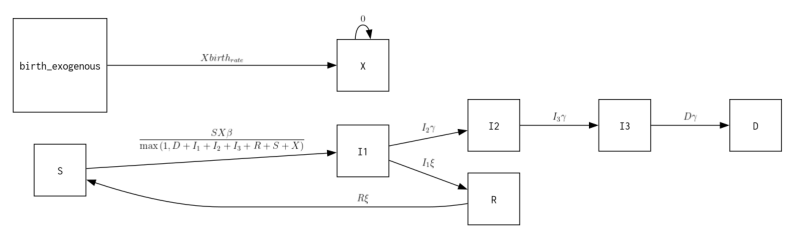

In [6]:
##model conceptual diagram

SIRS_TREES().diagram()

In [8]:
from functools import cached_property

import numpy as np
from numpy.typing import NDArray

from epymorph.attribute import AttributeDef
from epymorph.data_shape import Shapes
from epymorph.data_type import CentroidType, SimDType
from epymorph.movement_model import EveryDay, MovementClause, MovementModel
from epymorph.simulation import Tick, TickDelta, TickIndex
from epymorph.util import pairwise_haversine, row_normalize


class CentroidsClause(MovementClause):
    """The clause of the centroids model."""

    requirements = (
        AttributeDef(
            "population", int, Shapes.N, comment="The total population at each node."
        ),
        AttributeDef(
            "centroid",
            CentroidType,
            Shapes.N,
            comment="The centroids for each node as (longitude, latitude) tuples.",
        ),
        AttributeDef(
            "phi",
            float,
            Shapes.Scalar,
            default_value=40.0, #can this be NA since we dont know how far they can travel?
            comment="Influences the distance that movers tend to travel.",
        ),
        AttributeDef(
            "commuter_proportion",
            float,
            Shapes.Scalar,
            default_value=0.1,
            comment="The proportion of the total population which commutes.",
        ),
    )

    predicate = EveryDay()
    leaves = TickIndex(step=0)
    returns = TickDelta(step=1, days=0)

    @cached_property
    def dispersal_kernel(self) -> NDArray[np.float64]:
        """
        The NxN matrix or dispersal kernel describing the tendency for movers to move
        to a particular location. In this model, the kernel is:
            1 / e ^ (distance / phi)
        which is then row-normalized.
        """
        centroid = self.data("centroid")
        phi = self.data("phi")
        distance = pairwise_haversine(centroid)
        return row_normalize(1 / np.exp(distance / phi))

    def evaluate(self, tick: Tick) -> NDArray[np.int64]:
        pop = self.data("population")
        comm_prop = self.data("commuter_proportion")
        n_commuters = np.floor(pop * comm_prop).astype(SimDType)
        return self.rng.multinomial(n_commuters, self.dispersal_kernel)

class BeetleAwayClause(MovementClause):
    """Clause for beetles that leave home and stay away all day."""

    requirements = CentroidsClause.requirements  # same requirements
    #NEVER = TickDelta(step=0, days=0)  # negative day signals "never" in epymorph

    predicate = EveryDay()
    leaves = TickIndex(step=0)   # they leave at start
    returns = TickDelta(step=0, days=0)  # no return within the day!
    #returns = NEVER #They never return
    


    @cached_property
    def dispersal_kernel(self) -> NDArray[np.float64]:
        centroid = self.data("centroid")
        phi = self.data("phi")
        distance = pairwise_haversine(centroid)
        return row_normalize(1 / np.exp(distance / phi))

    def evaluate(self, tick: Tick) -> NDArray[np.int64]:
        pop = self.data("population")
        comm_prop = self.data("commuter_proportion")
        n_commuters = np.floor(pop * comm_prop).astype(SimDType)
        return self.rng.multinomial(n_commuters, self.dispersal_kernel)

class Centroids(MovementModel):
    """
    The centroids MM describes a basic commuter movement where a fixed proportion
    of the population commutes every day, travels to another location for 1/3 of a day
    (with a location likelihood that decreases with distance), and then returns home for
    the remaining 2/3 of the day.
    """

    steps = (1 / 3, 2/ 3) 
    clauses = (CentroidsClause(),)

class BeetleAwayAllDay(MovementModel):
    """Beetles leave home and stay away all day."""
    steps = (1.0,)   # only one step
    clauses = (BeetleAwayClause(),) # probalility that the BB travels 3/3 times of the day and also returns 3/3 times of the day.




In [9]:
## import climate variable from ADIRO

from datetime import date
from epymorph.kit import *
from epymorph.kit import *
from epymorph.adrio import us_tiger, prism, humidity

precip_adrio = prism.Precipitation()
mean_temp_adrio = prism.Temperature("Mean")

with sim_messaging(live=False):
    relH = (
        humidity.RelativeHumidity()
        .with_context(
            scope=scope,
            time_frame=TimeFrame.rangex("2021-01-01", "2021-01-30"), ## the simulation will run for a 3 years,
            params={
                "centroid": centroids,
                "temperature": prism.Temperature("Mean"),
                "dewpoint": prism.DewPoint(),
            },
        )
        .evaluate()
    )

Loading (unspecified)::(unspecified)::temperature (epymorph.adrio.prism.Temperature):
  |####################| 100%  (3.989s)
Loading (unspecified)::(unspecified)::dewpoint (epymorph.adrio.prism.DewPoint):
  |####################| 100%  (3.347s)
Loading epymorph.adrio.humidity.RelativeHumidity:
  |####################| 100%  (0.002s)


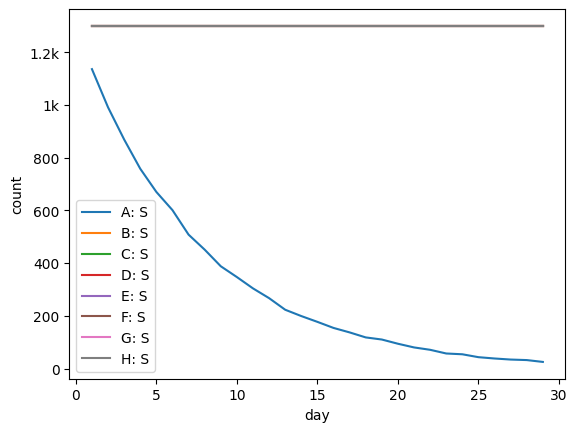

In [10]:
from epymorph.kit import *
from epymorph.adrio import us_tiger


rume = SingleStrataRUME.build(
    #ipm=ipm.SIRS(),
    ipm=SIRS_TREES(),
    #mm=mm.Centroids(),
    mm=BeetleAwayAllDay(),
    #init=init.SingleLocation(location=0, seed_size=100),
    init=init.Explicit([
        [1_300, 0, 0, 0, 0, 0, 1_000],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0]
    ]),
    #scope=StateScope.in_states(["AZ", "CO", "NM", "UT"], year=2020),
    scope=CustomScope(["A", "B", "C", "D", "E", "F", "G", "H"]),
    time_frame=TimeFrame.rangex("2021-01-01", "2021-01-30"), 
    params={
        "beta": 0.3,
        "gamma": 1/5,
        "xi": 1/365,
        "birth_rate": 1 / (70 * 365), ## how much do they reproduce in a year?
        "temperature": mean_temp_adrio,
        "precipitation": precip_adrio,
        "relative humidity": relH,
        "population": [
            #4_151_502, # Arizona
            #4_773_714, # Colorado
            #4_117_522#, # New Mexico
            #4_271_616, # Utah
            1_326, #total tree population per 100m by 100m grid
            1_326,
            1_326,
            1_326,
            1_326,
            1_326,
            1_326,
            1_326
        ],
        "centroid": centroids,
    },
)

sim = BasicSimulator(rume)
output = sim.run(rng_factory=default_rng(42))

output.plot.line(
    geo=output.rume.scope.select.all(),
    time=output.rume.time_frame.select.all(),
    quantity=output.rume.ipm.select.compartments("S"),
)

In [ ]:
##model conceptual diagram

SIRS_TREES().diagram()

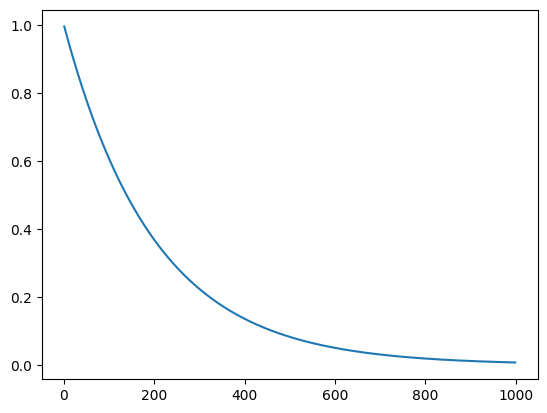

In [11]:
##prob of occuring aganist distance:

import matplotlib.pyplot as plt
phi = 200.0 ##can be any value but good to find a constant
xs = np.arange(1,1000) #this should be the actual distance between the grid cells A
ys = 1 / np.exp(xs / phi)

plt.plot(xs, ys)
plt.show()

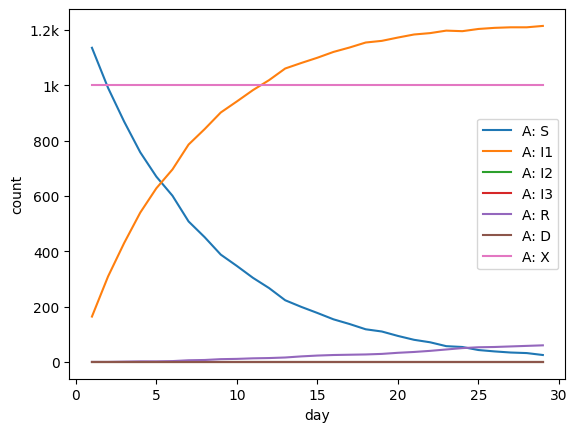

In [12]:
## plot of how all the grid cells compartments will behave

output.plot.line(
    geo=output.rume.scope.select.by_id('A'),
    time=output.rume.time_frame.select.all(),
    quantity=output.rume.ipm.select.compartments(),
)

## Estimating space- and time-varying transmission rate from data
# Exercise 1


In [13]:
scope = CustomScope(["A", "B", "C", "D", "E", "F", "G", "H"])
scope.labels

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], dtype='<U1')

In [14]:
#INIT

init=init.Explicit([
        [1_300, 0, 0, 0, 0, 0, 1_000],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0]
    ]),

In [15]:
import numpy as np

from epymorph.kit import *
from epymorph.adrio import acs5
from epymorph.initializer import Proportional

In [16]:

#Construct a RUME with a scope consisting of our scope, 
# but assume that there is no movement between the states. Essentially, 
# this simulates four independent populations. Use an SIRH IPM. In each State, 
# initialize a small fraction initially infectious. Run for 26 weeks.

n = 8 #number of scope
rume = SingleStrataRUME.build(
    #ipm=ipm.SIRH(),
    ipm=SIRS_TREES(),
    mm=mm.No(),
    scope=scope,
    init=Proportional(
        ratios=np.broadcast_to(
            np.array([9999, 1, 0, 0, 0, 0, 0], dtype=np.int64), shape=(n, 7) #number of individual in each compartment, so S= 9999 etc.
        )
    ),
    #init=init,
    time_frame=TimeFrame.of("2023-07-15", 7 * 26 + 1),
    params={
        "beta": 0.3,  # Placeholder value
        "gamma": 0.2,
        "xi": 1 / 365,
        "birth_rate": 1 / (70 * 365), ## how much do they reproduce in a year?
        "hospitalization_prob": 200 / 100_000,
        "hospitalization_duration": 5.0, ##ask tyler if this duration can be made into number of days the insect stays in a particular tree etc
        "population": [
            #4_151_502, # Arizona
            #4_773_714, # Colorado
            #4_117_522#, # New Mexico
            #4_271_616, # Utah
            1_326, #total tree population per 100m by 100m grid
            1_326,
            1_326,
            1_326,
            1_326,
            1_326,
            1_326,
            1_326
        ],
    },
)

In [17]:
#Specify the parameters to be estimated, 
# modeling the beta in each state using geometric Brownian motion with a uniform initial distribution.

from epymorph.parameter_fitting.distribution import Uniform
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters
from epymorph.parameter_fitting.dynamics import GeometricBrownianMotion

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.1, b=0.8),
        dynamics=GeometricBrownianMotion(volatility=0.1),
    ),
}

In [19]:
#Specify the filter type (Particle Filter). 
# Note that here is where we could specify the resampler used by the filter, 
# but we’ll just use the default (not localized).

from epymorph.parameter_fitting.filter.particle_filter import ParticleFilter

filter_type = ParticleFilter(num_particles=300)

In [47]:

from epymorph.adrio.cdc import InfluenzaStateHospitalization
from epymorph.parameter_fitting.likelihood import Poisson
from epymorph.parameter_fitting.utils.observations import ModelLink, Observations
from epymorph.time import EveryNDays

observations = Observations(
    source=mean_temp_adrio,
    model_link=ModelLink(
        quantity=rume.ipm.select.events("I3->D"),
        time=rume.time_frame.select.all().group(EveryNDays(7)).agg(),
        geo=rume.scope.select.all(),
    ),
    likelihood=Poisson(),
)

print(observations)

In [ ]:
#Create the filter simulation object using the RUME.

from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation

sim = FilterSimulation(
    rume=rume,
    observations=observations,
    filter_type=filter_type,
    params_space=params_space,
)

# Exercise 3

In [26]:
#Create a new RUME, specifying a commuter movement model.

from epymorph.adrio import commuting_flows

rume = SingleStrataRUME.build(
    ipm=SIRS_TREES(),
    mm=mm.Pei(),
    scope=scope,
    init=Proportional(
        ratios=np.broadcast_to(
            np.array([9999, 1, 0, 0, 0, 0, 0], dtype=np.int64), shape=(8, 7)
        )
    ),
    time_frame=TimeFrame.of("2022-09-15", 7 * 26 + 1),
    params={
        "beta": 0.3,  # Placeholder value
        "gamma": 0.2,
        "xi": 1 / 365,
        "birth_rate": 1 / (70 * 365), ## how much do they reproduce in a year?
        "hospitalization_prob": 200 / 100_000,
        "hospitalization_duration": 5.0,
        "population": [
            #4_151_502, # Arizona
            #4_773_714, # Colorado
            #4_117_522#, # New Mexico
            #4_271_616, # Utah
            1_326, #total tree population per 100m by 100m grid
            1_326,
            1_326,
            1_326,
            1_326,
            1_326,
            1_326,
            1_326
        ],
        "commuters": commuting_flows.Commuters(),
        "centroids":centroids,
    },
)

In [27]:
#Create a copy of the RUME, but where the commuter matrix is precomputed.

import dataclasses
from epymorph.attribute import AbsoluteName, NamePattern

name = AbsoluteName(strata="gpm:all", module="mm", id="commuters")
attr_def = rume.requirements[name]

# Precompute the commuter matrix.
rng = np.random.default_rng(seed=1)
data_resolver = rume.evaluate_params(rng=rng)
commuter_matrix = data_resolver.resolve(name, attr_def)

# Create a copy of the RUME, but with the commuter matrix replaced.
params_copy = dict(rume.params)
params_copy[NamePattern.of(name.id)] = commuter_matrix
rume_copy = dataclasses.replace(rume, params=params_copy)

ADRIOContextError: Invalid context for gpm:all::mm::commuters (gpm:all::mm::commuters): US State or County geo scope required.